# <center> Практика. Статистические тесты в контексте EDA

# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

## Постановка задачи

Необходимо исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе анализа необходимо:

* Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

* тесты для количественного признака: для одной выборки,для двух выборо,для нескольких выборок;
* тест для категориальных признаков.


На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере IT за 2020-2022 года , собранные в датасете “Data Science Job Salaries”.

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://lms-cdn.skillfactory.ru/assets/courseware/v1/9e84f30c5bc84881a5e33262d5e32a8b/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ds_salaries.zip)

Данные содержат следующие столбцы:

![](img/Tab.png)
![](img/Tab2.png)

## Загрузка данных

In [101]:
 
# data
import pandas as pd
import numpy as np 
import scipy.stats as st 
import math

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px  
import plotly.figure_factory as ff
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import warnings 

warnings.filterwarnings("ignore")


In [102]:
# загружаем датасет  
df = pd.read_csv('data/ds_salaries.csv')

display(df.head())

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [103]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

#### Создание новых признаков :

  1.  company_location_name   - Страна главного офиса работодателя или филиала по контракту, наименование 
  2.  experience_level_code   - Опыт работы на этой должности в течение года , числовой код ( 1 - EN — Entry-level/Junior , 2 - MI — Mid-level/Intermediate , 3 - SE — Senior-level/Expert , 4 - EX — Executive-level/Director)
  3.  employment_type_code    - Тип трудоустройства, числовой код (1 - PT — неполный рабочий день, 2 - FT — полный рабочий день, 3 - CT — контракт , 4 - FL — фриланс)
  4.  company_size_code       - Среднее количество людей, работавших в компании в течение года, числовой код ( 1 - S — менее 50 сотрудников (небольшая компания), 2 - M — от 50 до 250 сотрудников (средняя компания), 3 - L — более 250 сотрудников (крупная компания))
  5.  job_title_mapp - Роль , в которой соискатель работал в течении года , числовой код (0 - others, 1 - Data_Scientist, 2 - Data_Engineer )
  6.  income_sum - доход страны на душу населения 
  7.  group_income - группа по доходности на душу населения : 1 - менее 30000 , 2 - от 30000 до 60000 , 3 - 60000 до 90000 , более 90000  

In [105]:
# Кодирование признаков  
 
def country_mapp(country_code):
    """ Функция преобразования кода страны в ее наименование
           Args: ([string]) - строка с кодом страны
           Return: ([string]) - строка с наименованием страны
    """
    country_name = np.nan
    country_names = {
    'DE': 'Германия','JP': 'Япония', 'GB': 'Великобритания', 'HN': 'Гондурас','US': 'США', 'HU': 'Венгрия',
    'NZ': 'Новая Зеландия','FR': 'Франция','IN': 'Индия','PK': 'Пакистан','PL': 'Польша','PT': 'Португалия','CN': 'Китай',
    'GR': 'Греция','AE': 'Объединенные Арабские Эмираты','NL': 'Нидерланды','MX': 'Мексика','CA': 'Канада','AT': 'Австрия',
    'NG': 'Нигерия','PH': 'Филиппины','ES': 'Испания','DK': 'Дания','IT': 'Италия','HR': 'Хорватия','AE': 'ОАЭ',
    'PT': 'Португалия','LU': 'Люксембург','SG': 'Сингапур','RO': 'Румыния', 'IQ': 'Ирак',
    'BR': 'Бразилия','BE': 'Бельгия','UA': 'Украина','IL': 'Израиль','RU': 'Россия','MT': 'Мальта','CL': 'Чили',
    'IR': 'Иран','CO': 'Колумбия', 'KE': 'Кения','SI': 'Словения','CH': 'Швейцария','VN': 'Вьетнам',
    'AS': 'Американское Самоа','TR': 'Турция','CZ': 'Чехия','DZ': 'Алжир','EE': 'Эстония','MY': 'Малайзия','AU': 'Австралия',
    'IE': 'Ирландия','BG': 'Болгария','HK': 'Гонконг','RS': 'Сербия','PR': 'Пуэрто-Рико', 'JE': 'Остров Джерси', 
    'AR': 'Аргентина','TN': 'Тунис','BO': 'Боливия','MD': 'Молдавия'
    }   
    if country_code in country_names:
        country_name = country_names[country_code]
    return country_name
 
def experience_level_mapp(experience_level_code): 
    """ Функция преобразования признака "Опыт работы на этой должности в течение года" со следующими возможными значениями:
           1 - EN — Entry-level/Junior;
           2 - MI — Mid-level/Intermediate;
           3 - SE — Senior-level/Expert;
           4 - EX — Executive-level/Director
           Args: ([string]) - строка с кодом уровня специалиста
           Return: ([integer]) - числовой код уровня специалиста
    """
    experience_level_int = np.nan
    experience_level_names = {'EN' : 1, 'MI' : 2, 'SE':3, 'EX':4}   
    if experience_level_code in experience_level_names:
        experience_level_int = experience_level_names[experience_level_code] 
    return int(experience_level_int)

def employment_type_mapp(employment_type_code): 
    """ Функция преобразования признака "Тип трудоустройства" для этой роли:
            1 - PT — неполный рабочий день;
            2 - FT — полный рабочий день;
            3 - CT — контракт;
            4 - FL — фриланс.
           Args: ([string]) - строка с кодом типа трудоустройства
           Return: ([integer]) - числовой код типа трудоустройства
    """
    employment_type_int = np.nan
    employment_type_names = {'PT': 1,'FT':2,'CT':3,'FL':4}   
    if employment_type_code in employment_type_names:
        employment_type_int = employment_type_names[employment_type_code] 
    return int(employment_type_int)

# приведение категориального признака к числовому 
def company_size_mapp(company_size):
    """ Функция преобразования признака "Среднее количество людей, работавших в компании в течение год"а:
             1 - S — менее 50 сотрудников (небольшая компания);
             2 - M — от 50 до 250 сотрудников (средняя компания);
             3 - L — более 250 сотрудников (крупная компания)
           Args: ([string]) - строка с кодом размера компании
           Return: ([integer]) - числовой код размера компании
    """
    company_size_int = np.nan
    company_size_names = {'S': 1,'M':2,'L':3}   
    if company_size in company_size_names:
        company_size_int = company_size_names[company_size] 
    return int(company_size_int)

def job_title_mapp(job_title):
    """ Функция преобразования признака "Роль" , в которой соискатель работал в течении года , числовой код
           0 - others, 1 - Data_Scientist, 2 - Data_Engineer
           Args: ([string]) - строка с наименованием должности
           Return: ([integer]) - числовой код должности 
    """
    v_job_mapp = 0 # others
    
    v_Data_Scientist = ['AI Scientist','Analytics Engineer','Applied Data Scientist','Applied Machine Learning Scientist'
                        ,'Data Analytics Engineer','Data Science Engineer' 
                        ,'Data Scientist','Machine Learning Scientist','NLP Engineer','Principal Data Scientist'
                        ,'Research Scientist','Staff Data Scientist','Lead Data Scientist','Head of Machine Learning','Head of Data Science'
                        ,'Director of Data Science','ML Engineer','Data Science Consultant','Data Science Manager','Data Specialist'
                        ,'Machine Learning Developer']

    v_Data_Engineer = ['Data Engineer','Data Engineering Manager','Lead Data Engineer ','Lead Machine Learning Engineer','Machine Learning Engineer'
                      ,'Principal Data Engineer','Head of Data','Director of Data Engineering','Lead Data Engineer','Lead Data Engineer'
                      ,'Machine Learning Infrastructure Engineer','Data Architect']
    
    if job_title in v_Data_Scientist:
        v_job_mapp = 1 # Data_Scientist
    elif job_title in v_Data_Engineer:
        v_job_mapp = 2 # Data_Engineer  
    return v_job_mapp
 
def group_income_mapp(income_sum):
    """Функция определяющаа группу доходности на душу населения
       Args:[int64] - доход на душу населения по стране
       Return:[int64]  - группа по даходам на душу населения по стране :
                                 1 - менее 30000 , 2 - от 30000 до 60000 , 3 - 60000 до 90000 , более 90000  
    """
    gp = np.nan
    if income_sum > 90000:
       gp = 4
    elif income_sum >= 60000 and income_sum <= 90000:
       gp = 3
    elif income_sum >= 30000 and income_sum <= 60000:
       gp = 2
    else:
       gp = 1 
    return gp  


# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
     


# Создание новых признаков

# Страна главного офиса работодателя или филиала по контракту
df['company_location_name'] = df['company_location'].apply(country_mapp)

# Опыт работы на этой должности в течение года со следующими возможными значениями:
# 1 - EN — Entry-level/Junior;
# 2 - MI — Mid-level/Intermediate;
# 3 - SE — Senior-level/Expert;
# 4 - EX — Executive-level/Director.
df['experience_level_code'] = df['experience_level'].apply(experience_level_mapp) 

# Тип трудоустройства для этой роли:
# 1 - PT — неполный рабочий день;
# 2 - FT — полный рабочий день;
# 3 - CT — контракт;
# 4 - FL — фриланс.
df['employment_type_code']  = df['employment_type'].apply(employment_type_mapp)

# Среднее количество людей, работавших в компании в течение года:
# 1 - S — менее 50 сотрудников (небольшая компания);
# 2 - M — от 50 до 250 сотрудников (средняя компания);
# 3 - L — более 250 сотрудников (крупная компания).
df['company_size_code'] = df['company_size'].apply(company_size_mapp)

# Роль , в которой соискатель работал в течении года , числовой код (0 - others, 1 - Data_Scientist, 2 - Data_Engineer )
df_cnt = df.groupby(['job_title'])['job_title'].count().reset_index(name = 'count') 

print('Количественные данные по признаку "job_title" :')
display(df_cnt.sort_values(by = 'count',ascending= False)) # -----------  было  -----------------
df['job_title_mapp'] = df['job_title'].apply(job_title_mapp)

print('Количественные данные по признаку "job_title_mapp" (0 - others, 1 - Data_Scientist, 2 - Data_Engineer) :')
df_cnt = df.groupby(['job_title_mapp'])['job_title_mapp'].count()
display(df_cnt) # ----------   стало -----------------

print('Количественные данные по признаку job_title по маске  job_title_mapp = 0 (others) :')
mask = df['job_title_mapp'] == 0
df_cnt = df[mask].groupby(['job_title'])['job_title'].count().reset_index(name = 'count') 
display(df_cnt.sort_values(by = 'count',ascending= False)) # ----------   others ----------------  


Количественные данные по признаку "job_title" :


,job_title,count
22,Data Scientist,143
17,Data Engineer,132
12,Data Analyst,97
38,Machine Learning Engineer,41
48,Research Scientist,16
21,Data Science Manager,12
16,Data Architect,11
7,Big Data Engineer,8
41,Machine Learning Scientist,8
25,Director of Data Science,7


Количественные данные по признаку "job_title_mapp" (0 - others, 1 - Data_Scientist, 2 - Data_Engineer) :


job_title_mapp
0    151
1    247
2    209
Name: job_title_mapp, dtype: int64

Количественные данные по признаку job_title по маске  job_title_mapp = 0 (others) :


,job_title,count
8,Data Analyst,97
3,Big Data Engineer,8
10,Data Analytics Manager,7
6,Computer Vision Engineer,6
1,BI Data Analyst,6
4,Business Data Analyst,5
7,Computer Vision Software Engineer,3
14,Lead Data Analyst,3
18,Product Data Analyst,2
17,Principal Data Analyst,2


In [106]:
# Создаем словать по странам с доходом на душу населения (список стран возьмем с сайта Википедии , 
# статья "Список стран по ВВП (номинал) на душу населения") , по нему будем определять уровень жизни в стране
# Создаем новый признак income_sum - доход страны на душу населения

# Загрузка страницы
url =  'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D1%82%D1%80%D0%B0%D0%BD_%D0%BF%D0%BE_%D0%92%D0%92%D0%9F_(%D0%BD%D0%BE%D0%BC%D0%B8%D0%BD%D0%B0%D0%BB)_%D0%BD%D0%B0_%D0%B4%D1%83%D1%88%D1%83_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F'
response = requests.get(url, verify=False)

# Парсинг HTML с помощью BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Находим таблицу с данными
table = soup.find('table', {'class': 'wikitable sortable'})

my_dict = dict()
# Извлекаем данные из таблицы
for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 1:
        country = cells[1].text.strip()
        income = int(round(float((cells[2].text.strip().replace('\xa0', '').replace(' ', ''))))) # Удаляем пробелы и неразрывные пробелы
        my_dict[country] = income
       

#print(my_dict)
        
def  income(country):
    """ Функция получения дохода страны на душу населения
           Args: ([string]) - строка с наименованием страны 
           Return: ([integer]) - доход на душу населения в стране
    """
    income_sum = np.nan
    if country in my_dict:
        income_sum = my_dict[country]
    
    return income_sum     

df['income_sum'] = df['company_location_name'].apply(income)    
# Создадим новый признак "group_income" - группа доходности страны на душу населения
df['group_income'] = df['income_sum'].apply(group_income_mapp) 

#### Очистка данных 


> для анализа будем использовать три датасета :
  * Исходный датасет df, обогащенный новыми признаками 
  * Очищенный датасет df_clear по необходимым признакам
  * Очищенный датасет df_DS по специалистам Data Scientist 

#### В очищенном датасете нас интересуют должности только Data Scientist и Data Engineer на полный рабочий день или контракт 

##### Выберем признаки для нового датасета df_clear и ограничим выборку только по двум ролям Data Scientist и Data Engineer:
*  work_year - год
*  salary_in_usd - ЗП в долларах
*  remote_ratio 
*  company_location_name   - Страна главного офиса работодателя или филиала по контракту, наименование 
*  experience_level_code   - Опыт работы на этой должности в течение года , числовой код ( 1 - EN — Entry-level/Junior , 2 - MI — Mid-level/Intermediate , 3 - SE — Senior-level/Expert , 4 - EX — Executive-level/Director)
*  employment_type_code    - Тип трудоустройства, числовой код (1 - PT — неполный рабочий день, 2 - FT — полный рабочий день, 3 - CT — контракт , 4 - FL — фриланс)
*  company_size_code       - Среднее количество людей, работавших в компании в течение года, числовой код ( 1 - S — менее 50 сотрудников (небольшая компания), 2 - M — от 50 до 250 сотрудников (средняя компания), 3 - L — более 250 сотрудников (крупная компания))
*  job_title_mapp - Роль , в которой соискатель работал в течении года , числовой код (0 - others, 1 - Data_Scientist, 2 - Data_Engineer )
*  income_sum - доход страны на душу населения 
*  group_income - группа по доходности на душу населения : 1 - менее 30000 , 2 - от 30000 до 60000 , 3 - 60000 до 90000 , более 90000  

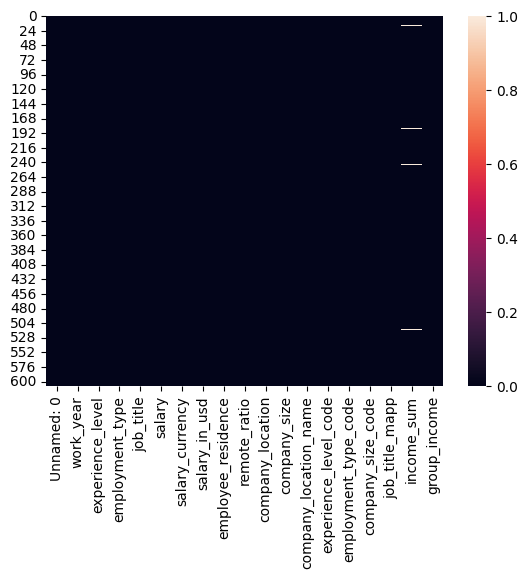


Смотрим, чего не хватает:


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_location_name,experience_level_code,employment_type_code,company_size_code,job_title_mapp,income_sum,group_income
15,15,2020,MI,FT,Data Analyst,8000,USD,8000,PK,50,PK,L,Пакистан,2,2,3,0,NaN,1
184,184,2021,MI,FL,Machine Learning Scientist,12000,USD,12000,PK,50,PK,M,Пакистан,2,4,2,1,NaN,1
244,244,2021,EN,FT,AI Scientist,1335000,INR,18053,IN,100,AS,S,Американское Самоа,1,2,1,1,NaN,1
514,514,2022,EN,FT,Data Analytics Engineer,20000,USD,20000,PK,0,PK,M,Пакистан,1,2,2,1,NaN,1



Добавили недостающие данные

-----------------------------------------------
Пропуски в данных :
-----------------------------------------------
work_year                0
salary_in_usd            0
remote_ratio             0
company_location_name    0
experience_level_code    0
employment_type_code     0
company_size_code        0
job_title_mapp           0
income_sum               0
group_income             0
dtype: int64

-----------------------------------------------
Количество дубликатов: 31
Размер таблицы после удаления дубликатов: (415, 10)


In [107]:
# наглядная карта пропусков
sns.heatmap(df.isnull()) 
plt.show() 
print()
print('Смотрим, чего не хватает:')
isnll = df[df.isnull().any(axis=1)]
display(isnll)
print()
# Подгрузим в справочник недостающие данные 
print('Добавили недостающие данные')
my_dict['Пакистан'] = 1548  
my_dict['Американское Самоа'] = 8000
df['income_sum'] = df['company_location_name'].apply(income)   
print()

# Формируем очищенный датасет
mask1 = ((df['job_title_mapp'] > 0))
mask2 = ((df['employment_type_code'] == 2) | (df['employment_type_code'] == 3))

df_clear = df[mask1 & mask2].loc[:,['work_year','salary_in_usd','remote_ratio','company_location_name'
                                    ,'experience_level_code','employment_type_code','company_size_code'
                                    ,'job_title_mapp','income_sum','group_income']]


# Пропуски в данных
cols_null_percent = df_clear.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print('-----------------------------------------------')
print('Пропуски в данных :' )
print('-----------------------------------------------')
print(df_clear.isnull().sum())
print()
print('-----------------------------------------------')
print('Количество дубликатов: {}'.format(df_clear[df_clear.duplicated()].shape[0]))
# Удаляем дубликаты:
df_clear = df_clear.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df_clear.shape))



In [108]:
print('----------- df ------------------------------------')
df.info()

----------- df ------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             607 non-null    int64 
 1   work_year              607 non-null    int64 
 2   experience_level       607 non-null    object
 3   employment_type        607 non-null    object
 4   job_title              607 non-null    object
 5   salary                 607 non-null    int64 
 6   salary_currency        607 non-null    object
 7   salary_in_usd          607 non-null    int64 
 8   employee_residence     607 non-null    object
 9   remote_ratio           607 non-null    int64 
 10  company_location       607 non-null    object
 11  company_size           607 non-null    object
 12  company_location_name  607 non-null    object
 13  experience_level_code  607 non-null    int64 
 14  employment_type_code  

In [109]:
print('----------- df_clear ------------------------------------')
df_clear.info()

----------- df_clear ------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 0 to 606
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   work_year              415 non-null    int64 
 1   salary_in_usd          415 non-null    int64 
 2   remote_ratio           415 non-null    int64 
 3   company_location_name  415 non-null    object
 4   experience_level_code  415 non-null    int64 
 5   employment_type_code   415 non-null    int64 
 6   company_size_code      415 non-null    int64 
 7   job_title_mapp         415 non-null    int64 
 8   income_sum             415 non-null    int64 
 9   group_income           415 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 35.7+ KB


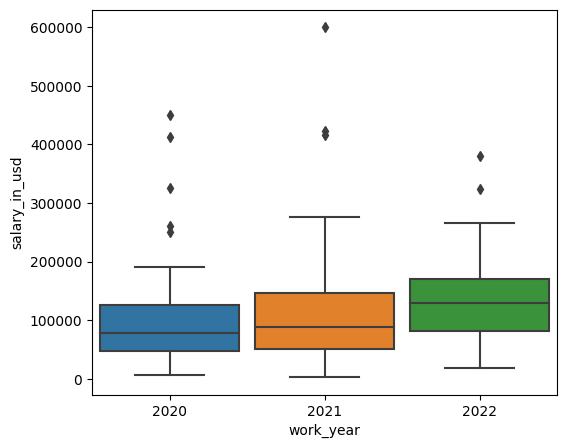

In [110]:
# Построим коробчатую диаграмму для признака "Зарплата в долларах США"(salary_in_usd) с группировкой по годам ('work_year')
 
fig = plt.figure(figsize=(6,5))
boxplot = sns.boxplot(
    data=df_clear,
    x='work_year',
    y='salary_in_usd', 
    orient='v',
    width=0.9
)

plt.show()

Наблюдается выбросы в сторону увеличения , что обусловлено включением в выборку должностей директоров и лидов с высокой зарплатой, анализ выбросов так же  показал наличие нелогичных записей с параметрами :
1. Компании с кол-вом работников менее 250 человек  , не могут платить ЗП более 200 тыс
2. Должность с низким уровнем экспертизы не может иметь ЗП более 200 тыс


In [111]:
# Удалим нелогичные выбросы

# ЗП более 200 тыс в 2020 году и ЗП более 300 тыс в 2021 и 2022 годах
mask1 = ((df_clear['work_year'] == 2020) & (df_clear['salary_in_usd'] > 200000))
mask2 = (((df_clear['work_year'] == 2021) | (df_clear['work_year'] == 2022)) & (df_clear['salary_in_usd'] > 300000))
# размер компании менее 250 чел или уровень экспертизы у работника ниже эксперта
mask4 = ((df_clear['company_size_code'] < 3) | (df_clear['experience_level_code'] < 3) )
#display(df_clear[(mask1 | mask2 | mask3) & mask4].head(20))
 
df_clear.drop(index = df_clear[(mask1 | mask2 ) & mask4].index,  inplace=True )   
print('Выбросов осталось : ')
display(df_clear[(mask1 | mask2) ].head(20))

# удалим оставшиеся 4 выброса 
df_clear.drop(index = df_clear[(mask1 | mask2 )].index,  inplace=True ) 

print('Выбросов осталось : ')
display(df_clear[(mask1 | mask2) ].head(20))

 

Выбросов осталось : 


,work_year,salary_in_usd,remote_ratio,company_location_name,experience_level_code,employment_type_code,company_size_code,job_title_mapp,income_sum,group_income
25,2020,325000,100,США,4,2,3,1,69375,3
63,2020,412000,100,США,3,2,3,1,69375,3
252,2021,600000,100,США,4,2,3,2,69375,3
519,2022,380000,100,США,3,2,3,1,69375,3


Выбросов осталось : 


,work_year,salary_in_usd,remote_ratio,company_location_name,experience_level_code,employment_type_code,company_size_code,job_title_mapp,income_sum,group_income


In [112]:
print('Статистика по числовым признакам :')
display(df_clear.describe())

Статистика по числовым признакам :


,work_year,salary_in_usd,remote_ratio,experience_level_code,employment_type_code,company_size_code,job_title_mapp,income_sum,group_income
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,2021.377778,111582.782716,69.135802,2.392593,2.007407,2.217284,1.464198,54294.893827,2.412346
std,0.684337,60526.110611,41.002220,0.781243,0.085853,0.676477,0.499333,21358.470457,0.741517
min,2020.000000,2859.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1548.000000,1.000000
25%,2021.000000,63831.000000,50.000000,2.000000,2.000000,2.000000,1.000000,46200.000000,2.000000
50%,2021.000000,104702.000000,100.000000,2.000000,2.000000,2.000000,1.000000,69375.000000,3.000000
75%,2022.000000,154000.000000,100.000000,3.000000,2.000000,3.000000,2.000000,69375.000000,3.000000
max,2022.000000,276000.000000,100.000000,4.000000,3.000000,3.000000,2.000000,131301.000000,4.000000


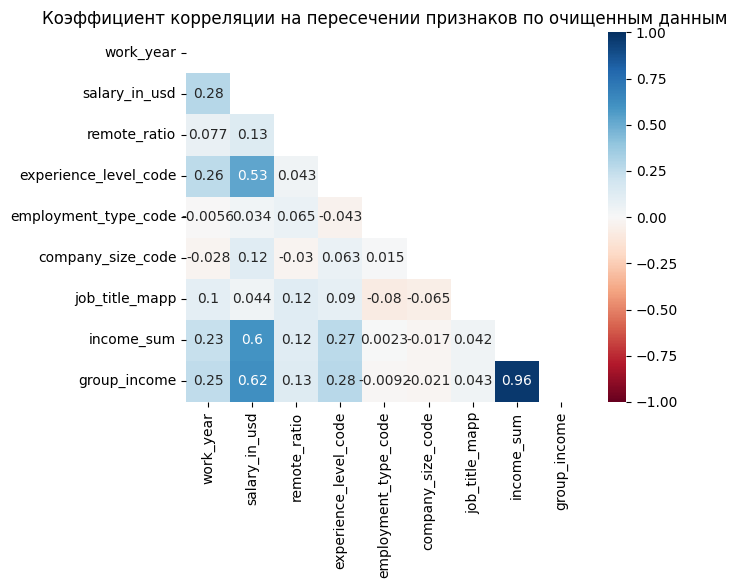

In [113]:
# Отобразим коэффициент корреляции на пересечении признаков  
sns.heatmap(df_clear.corr(numeric_only = True), 
            annot = True, 
            vmin = -1, 
            vmax = 1, 
            center = 0, 
            cmap = 'RdBu' , 
            mask=np.triu(df_clear.corr(numeric_only = True))  
            ) 
plt.title('Коэффициент корреляции на пересечении признаков по очищенным данным')
plt.show() 

In [114]:
# sns.pairplot(df_clear)

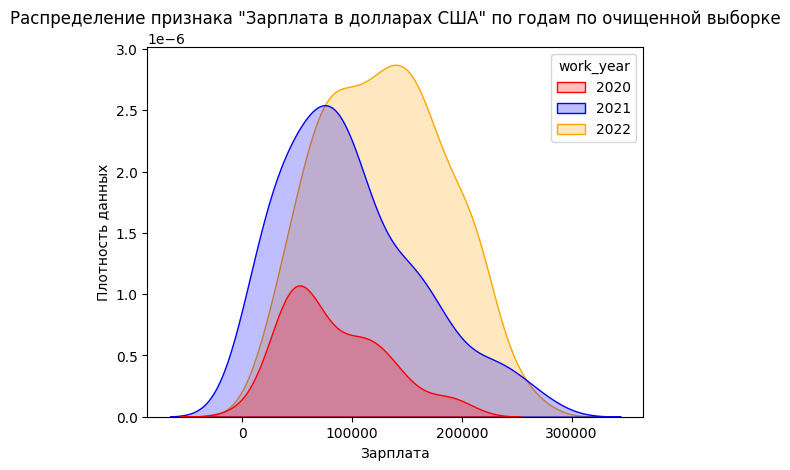

In [115]:
# Создание графика с усредненной линией kde по признаку "Зарплата в долларах США" 

colors = {2020: "red", 2021: "blue" , 2022: "orange" }
sns.kdeplot(data=df_clear, x='salary_in_usd', hue='work_year', fill=True , palette = colors)
plt.title('Распределение признака "Зарплата в долларах США" по годам по очищенной выборке')
plt.xlabel('Зарплата')
plt.ylabel('Плотность данных')
plt.show()

#### Вывод :
* Межквантильный размах по признакам из очищенного датасета: 
  1. Год, в котором была выплачена зарплата(work_year) - от 2021 до 2022
  2. Зарплата в долларах США(salary_in_usd) - от 63900 до 156600
  3. Общий объём работы, выполняемой удалённо(remote_ratio) - от 50% до 100%
  4. Опыт работы на этой должности в течение года(experience_level_code) - от Mid-level/Intermediate до Senior-level/Expert
  5. Тип трудоустройства для этой роли(employment_type_code) - Полный рабочий день , контракт
  6. Среднее количество людей, работавших в компании в течение года(company_size_code) - от 50 до 250 и более сотрудников
  7. Уровень дохода на душу населения по странам (income_sum) - от 46200 до 69375


* Коэффициент корреляции : 
  1. 0,53 - Средняя корреляция  у приизнаков Зарплата в долларах США(salary_in_usd) и Опыт работы на этой должности в течение года(experience_level_code)).
  2. 0,6 - Средняя корреляция  у приизнаков Зарплата в долларах США(salary_in_usd) и Уровень дохода на душу населения по странам (income_sum).

 У остальных признаков связь очень слабая или отсутствует.


* Признак по зарплате в долларах США(salary_in_usd) по годам после очистки данных:
  1. не имеет нормального распределения (относительно нуля) 
  2. медианное значение и плотность повышается с каждым годом , причем резкий скачек по медианному значению между 2021 и 2022 годом и резкий скачек в плотности данных между 2020 и 2021 годами

#### Вопросы по заданию проекта:

   1. Какие факторы влияют на зарплату специалиста Data Scientist?
   2. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
   3. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
   4. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
   5. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

##### 1. Какие факторы влияют на зарплату специалиста Data Scientist ?

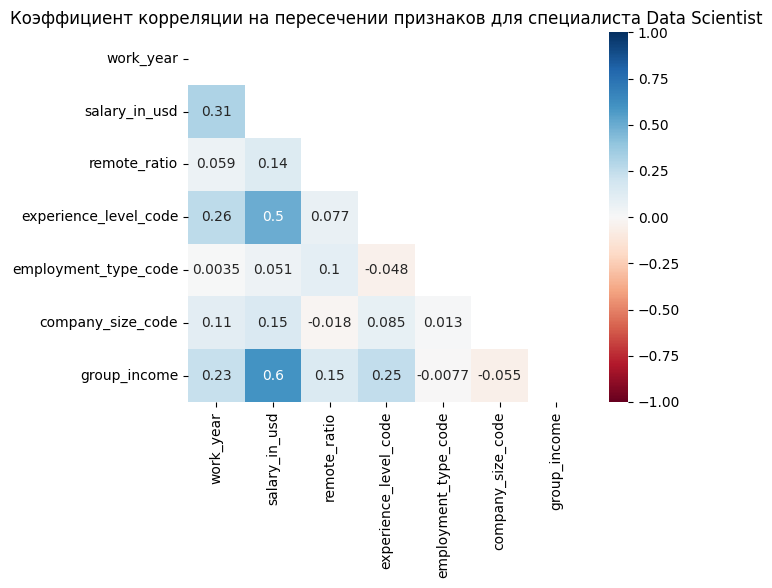

In [116]:
# Отобразим коэффициент корреляции на пересечении признаков для специалиста Data Scientist
# Создадим отдельную выборку для Date Scientist
df_DS = df_clear[df_clear['job_title_mapp'] == 1].loc[:,['work_year','salary_in_usd','remote_ratio','company_location_name'
                                    ,'experience_level_code','employment_type_code','company_size_code', 'group_income']]
# df_DS = df_DS.drop(columns = ['job_title_mapp' ,'income_sum'])
sns.heatmap(df_DS.corr(numeric_only = True), 
            annot = True, 
            vmin = -1, 
            vmax = 1, 
            center = 0, 
            cmap = 'RdBu' , 
            mask=np.triu(df_DS.corr(numeric_only = True))  
            ) 
plt.title('Коэффициент корреляции на пересечении признаков для специалиста Data Scientist')
plt.show() 

#####  2. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

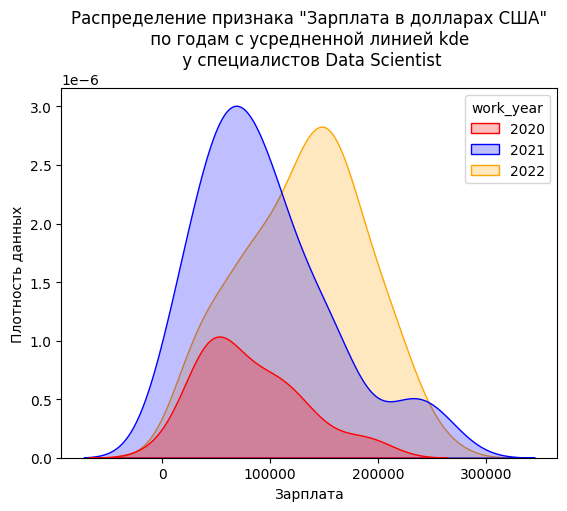

In [117]:
# Создание графика с усредненной линией kde по признаку "Зарплата в долларах США"
colors = {2020: "red", 2021: "blue" , 2022: "orange" }
sns.kdeplot(data=df_DS, x='salary_in_usd', hue='work_year', fill=True , palette=colors)
plt.title('Распределение признака "Зарплата в долларах США"\n по годам с усредненной линией kde \n у специалистов Data Scientist')
plt.xlabel('Зарплата')
plt.ylabel('Плотность данных')
plt.show()

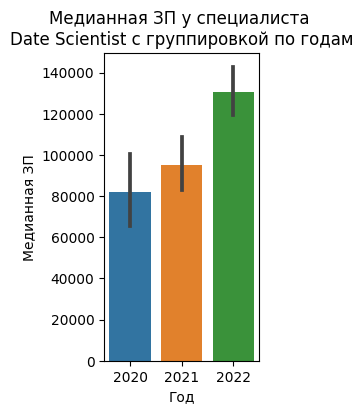

In [118]:
plt.figure(figsize = (2,4))
sns.barplot(x = 'work_year',y = 'salary_in_usd',data = df_DS)
plt.xlabel('Год')
plt.ylabel('Медианная ЗП')
plt.title('Медианная ЗП у специалиста \nDate Scientist с группировкой по годам')  
plt.show()

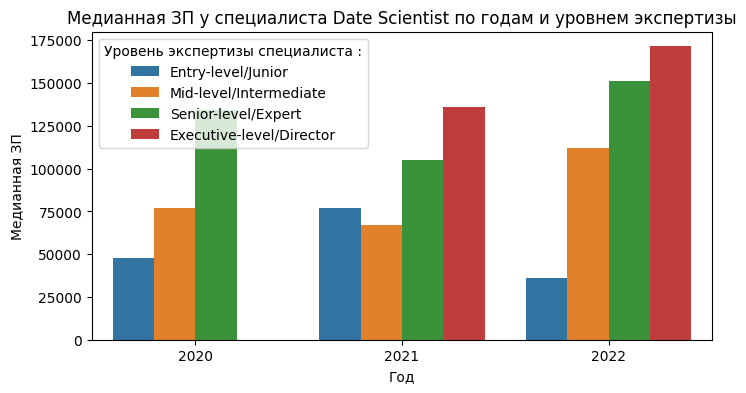

In [119]:
df_sal = df_clear[df_clear['job_title_mapp'] == 1].groupby(['work_year','experience_level_code'])['salary_in_usd'].median().reset_index()
plt.figure(figsize = (8,4))
sns.barplot(x = 'work_year',y = 'salary_in_usd',hue = 'experience_level_code',data = df_sal)
plt.xlabel('Год')
plt.ylabel('Медианная ЗП')
plt.title('Медианная ЗП у специалиста Date Scientist по годам и уровнем экспертизы')
legend_lablels = {'1' : 'Entry-level/Junior' , '2' : 'Mid-level/Intermediate' , '3' : 'Senior-level/Expert' , '4' :'Executive-level/Director' }
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [legend_lablels[label] for label in labels],
           title='Уровень экспертизы специалиста :')
plt.show()

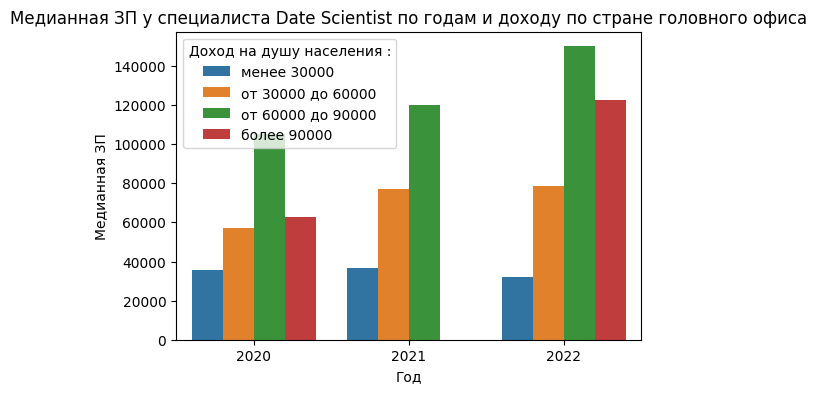

In [120]:
df_sal = df_clear[df_clear['job_title_mapp'] == 1].groupby(['work_year','group_income'])['salary_in_usd'].median().reset_index()
plt.figure(figsize = (6,4))
sns.barplot(x = 'work_year',y = 'salary_in_usd',hue = 'group_income',data = df_sal)
plt.xlabel('Год')
plt.ylabel('Медианная ЗП')
plt.title('Медианная ЗП у специалиста Date Scientist по годам и доходу по стране головного офиса')
legend_lablels = {'1' : 'менее 30000' , '2' : 'от 30000 до 60000' , '3' : 'от 60000 до 90000' , '4' :'более 90000' }
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [legend_lablels[label] for label in labels],
           title='Доход на душу населения :')
plt.show()

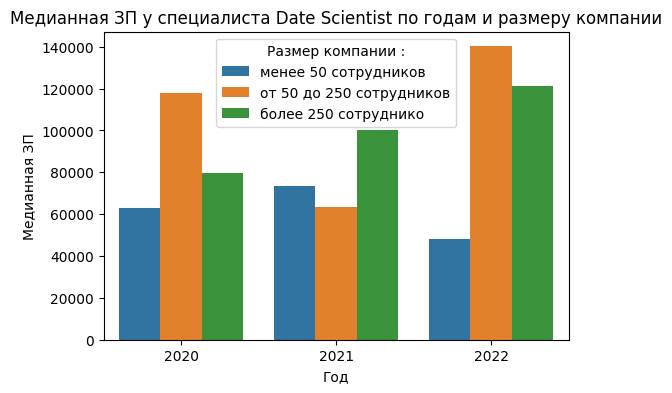

In [121]:

df_sal = df_clear[df_clear['job_title_mapp'] == 1].groupby(['work_year','company_size_code'])['salary_in_usd'].median().reset_index()
plt.figure(figsize = (6,4))
sns.barplot(x = 'work_year',y = 'salary_in_usd',hue = 'company_size_code',data = df_sal)
plt.xlabel('Год')
plt.ylabel('Медианная ЗП')
plt.title('Медианная ЗП у специалиста Date Scientist по годам и размеру компании')
legend_lablels = {'1' : 'менее 50 сотрудников' , '2' : 'от 50 до 250 сотрудников' , '3' : 'более 250 сотруднико' }
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [legend_lablels[label] for label in labels],
           title='Размер компании :')
plt.show()

> **Вывод** : 
 * Важными факторами , влияющими на зарплату специалиста Data Scientist, являются уровень экспертизы специалиста ,доход страны на душу населения , в которой находится горовной офис. 
 * Наблюдается ежегодный рост зарплат у специалистов Date Scientist , причем с 2020 по 2021 прирост незанчительный ,  но увеличивается плотность, в следующем году видим резкий скачек в сторону увеличения роста ЗП. Распределение зарплат по годам не является нормальным . 
 * Признак "размер компании" не влияет на уровень зарплаты специалиста


##### **Проверим Статистически значимы ли эти факторы**

##### Уровень экспертизы специалиста и его ЗП 

**Сформулируем нулевую и альтернативные гипотезы для проверки влияния уровня экспертьизы у специалиста Data Scientist на его зарплату:**

*Нулевая гипотеза* ($H_0$): средний уровень зарплаты у специалистов уровня Senior-level/Expert ($μ_1$)  равен среднему уровню зарплаты у специалистов уровня  Mid-level/Intermediate ($μ_2$) и среднему уровню зарплаты Entry-level/Junior ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): средний уровень зарплаты у специалистов уровня Senior-level/Expert ($μ_1$) не  равен среднему уровню зарплаты у специалистов уровня  Mid-level/Intermediate ($μ_2$) и среднему уровню зарплаты Entry-level/Junior ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [122]:
# значения зарплат в категориях по уровню экспертизы
charges_midl = df_DS.loc[df_DS['experience_level_code'] == 1, 'salary_in_usd']
charges_exp = df_DS.loc[df_DS['experience_level_code'] == 2, 'salary_in_usd']
charges_jn = df_DS.loc[df_DS['experience_level_code'] == 3, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата специалистов уровня Entry-level/Junior:')
result = st.shapiro(charges_jn)
decision_normality(result[1])

print('Зарплата специалистов Mid-level/Intermediate:')
result = st.shapiro(charges_midl)
decision_normality(result[1])

print('Зарплата специалистов Senior-level/Expert:')
result = st.shapiro(charges_exp)
decision_normality(result[1])

Зарплата специалистов уровня Entry-level/Junior:
p-value = 0.573
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата специалистов Mid-level/Intermediate:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата специалистов Senior-level/Expert:
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


> У нас три независимые группы с выборкой по колличественному признаку, признаки распределены не нормально , поэтому нам подойдет статистический тест по критерию Краскела-Уолиса , для сравнения средних значений  

In [123]:
# проводим тест 
_, p = st.kruskal(charges_midl , charges_exp , charges_jn )
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


> Подтвердили статистически , что размер ЗП у специалистов Data Scientist разного уровня различен. 

#### ЗП Data Scientist и доход страны на душу населения , в которой находится головной офис.

**Сформулируем нулевую и альтернативные гипотезы для проверки влияния дохода страны на душу населения , в которой находится горовной офис на ЗП специалиста Data Scientist :**

*Нулевая гипотеза* ($H_0$): средний уровень ЗП с низким уровнем дохода страны на душу населения  ($μ_1$)  больше либо равен среднему уровну ЗП со среднем уровнем дохода страны на душу населения ($μ_2$) и больше либо равен среднему уровню ЗП с высоким уровнем дохода страны на душу населения ($μ_3$)

$$ H_0 : μ_1 >= μ_2 >= μ_3$$

*Альтернативная гипотеза* ($H_1$): средний уровень ЗП с низким уровнем дохода страны на душу населения ($μ_1$)  меньше среднего уровня ЗП со среднем уровнем дохода страны на душу населения ($μ_2$) и меньше среднего уровня ЗП с высоким уровнем дохода страны на душу населения ($μ_3$)

$$ H_1 : μ_1 < μ_2 < μ_3$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [124]:
# значения зарплат
charges_1 = df_DS.loc[df_DS['group_income'] == 1, 'salary_in_usd']
charges_2 = df_DS.loc[df_DS['group_income'] == 2, 'salary_in_usd']
charges_3 = df_DS.loc[df_DS['group_income'] == 3, 'salary_in_usd'] 
 

# проводим тест Шапиро-Уилка
print('Зарплата специалистов - доход страны головного офиса на душу населения до 30000:')
result = st.shapiro(charges_1)
decision_normality(result[1])

print('Зарплата специалистов - доход страны головного офиса на душу населения от 30000 до 60000:')
result = st.shapiro(charges_2)
decision_normality(result[1])

print('Зарплата специалистов - доход страны головного офиса на душу населения от 60000 до 90000:')
result = st.shapiro(charges_3)
decision_normality(result[1]) 

Зарплата специалистов - доход страны головного офиса на душу населения до 30000:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата специалистов - доход страны головного офиса на душу населения от 30000 до 60000:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата специалистов - доход страны головного офиса на душу населения от 60000 до 90000:
p-value = 0.781
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [125]:
# Выполнение теста Краскела-Уоллиса
_, p_value = st.kruskal(charges_1, charges_2, charges_3)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


> Утверждение о том , что уровень дохода страны на душу населения влияет на средний уровень ЗП специалиста Data Scientist подтвердили статестически. 

#### Рост зарплат у специалистов Date Scientist с 2020 по 2022

Сравним поочередно средную ЗП в 2020 году со средней ЗП в 2021 году 
и средную ЗП в 2021 году со средней ЗП в 2022 году 

**Сформулируем нулевую и альтернативные гипотезы для проверки увеличения ЗП специалиста Data Scientist с 2020 по 2021 года:**

*Нулевая гипотеза* ($H_0$): средний уровень ЗП ($μ_1$) в 2020 году равен или больше среднему уровню ЗП в 2021 ($μ_2$) 
$$ H_0 : μ_1 >= μ_2$$ 

*Альтернативная гипотеза* ($H_1$):  средний уровень ЗП ($μ_1$) в 2020 году меньше среднего уровня ЗП в 2021 

$$ H_1 : μ_1 < μ_2$$ 



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [126]:
# значения зарплат у специалиста Data Scientist в 2020,2021,2022
salary_2020 = df_DS.loc[df_DS['work_year'] == 2020, 'salary_in_usd']
salary_2021 = df_DS.loc[df_DS['work_year'] == 2021, 'salary_in_usd']
salary_2022 = df_DS.loc[df_DS['work_year'] == 2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Зарплата у специалиста Data Scientist в 2020:')
result = st.shapiro(salary_2020)
decision_normality(result[1])

print('Зарплата у специалиста Data Scientist в 2021:')
result = st.shapiro(salary_2021)
decision_normality(result[1])

print('Зарплата у специалиста Data Scientist в 2022:')
result = st.shapiro(salary_2022)
decision_normality(result[1])

Зарплата у специалиста Data Scientist в 2020:
p-value = 0.036
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата у специалиста Data Scientist в 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Зарплата у специалиста Data Scientist в 2022:
p-value = 0.227
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Для проведеня теста будем использовать критерий Манна - Уитни

In [127]:
# проводим тест
_, p = st.mannwhitneyu(salary_2020, salary_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.201
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Сформулируем нулевую и альтернативные гипотезы для проверки увеличения ЗП специалиста Data Scientist с 2021 по 2022 года:**

*Нулевая гипотеза* ($H_0$): средний уровень ЗП ($μ_1$) в 2021 году равен или больше среднему уровню ЗП в 2022 ($μ_2$) 
$$ H_0 : μ_1 >= μ_2$$ 

*Альтернативная гипотеза* ($H_1$):  средний уровень ЗП ($μ_1$) в 2021 году меньше среднего уровня ЗП в 2022 

$$ H_1 : μ_1 < μ_2$$ 

In [128]:
# проводим тест
_, p = st.mannwhitneyu(salary_2021, salary_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


> Статистически подтвердили , что рост средней ЗП у специалистов Data Scientist с 2020 по 2021 не наблюдается и наоборот наблюдантся рост ЗП с 2021 по 2022 год

#### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

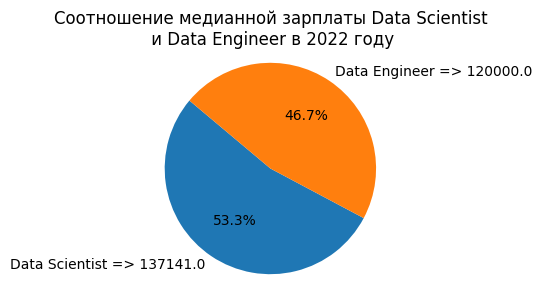

In [129]:
 
# Данные для круговой диаграммы
mask1 = (df_clear['job_title_mapp'] == 1) 
mask2 = (df_clear['job_title_mapp'] == 2) 
mask3 = (df_clear['work_year'] == 2022 )
sizes = [ df_clear[mask1 & mask3]['salary_in_usd'].median() 
         ,df_clear[mask2 & mask3]['salary_in_usd'].median()]
ds = 'Data Scientist => ' + str(sizes[0])
de = 'Data Engineer => '  + str(sizes[1])
labels = [ds,de]

# Создание круговой диаграммы
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Чтобы круговая диаграмма выглядела как круг

plt.title('Соотношение медианной зарплаты Data Scientist\n и Data Engineer в 2022 году') 
 

plt.show()

> зарплаты специалистов Data Scientist и Data Engineer в 2022 году не значительны

**Сформулируем нулевую и альтернативные гипотезы для проверки равентва средней ЗП специалиста Data Scientist и Data Engineer в 2022 году:**

*Нулевая гипотеза* ($H_0$): средний уровень ЗП специалиста Data Scientist ($μ_1$)  равен среднему уровню ЗП Data Engineer ($μ_2$)  в 2022    
$$ H_0 : μ_1 =  μ_2$$ 

*Альтернативная гипотеза* ($H_1$):  средний уровень ЗП специалиста Data Scientist ($μ_1$) в 2022 году Не равен среднему уровню ЗП Data Engineer ($μ_2$)  в 2022    

$$ H_1 : μ_1 \neq μ_2$$ 



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [130]:
# значения зарплат у специалиста Data Scientist и Data Engineer в 2022
salary_2022_DS = df_DS.loc[df_DS['work_year'] == 2022, 'salary_in_usd']
# Создадим датасет со специалистами Data Engineer
df_DE = df_clear[df_clear['job_title_mapp'] == 2].loc[:,['work_year','salary_in_usd','remote_ratio','company_location_name'
                                    ,'experience_level_code','employment_type_code','company_size_code', 'group_income']]
salary_2022_DE = df_DE.loc[df_DE['work_year'] == 2022, 'salary_in_usd'] 

# проводим тест Шапиро-Уилка
print('Зарплата у специалиста Data Scientist в 2022:')
result = st.shapiro(salary_2022_DS)
decision_normality(result[1])

print('Зарплата у специалиста Data Engineer в 2022:')
result = st.shapiro(salary_2022_DE)
decision_normality(result[1]) 

Зарплата у специалиста Data Scientist в 2022:
p-value = 0.227
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата у специалиста Data Engineer в 2022:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [131]:
# проводим тест
_, p = st.mannwhitneyu(salary_2022_DS, salary_2022_DE)
decision_hypothesis(p)

p-value = 0.453
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


> Тест показал , что средний уровень ЗП специалиста Data Scientist равен среднему уровню ЗП Data Engineer в 2022  

#### 4. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

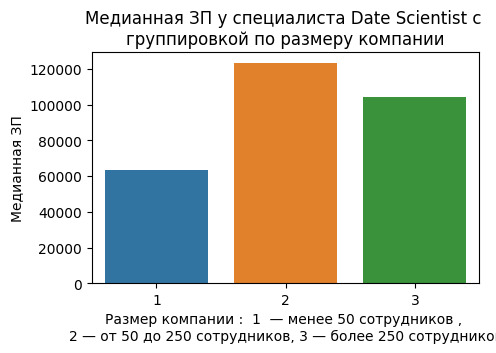

In [132]:
df_sal = df_DS.groupby(['company_size_code'])['salary_in_usd'].median().reset_index()
plt.figure(figsize = (5,3))
sns.barplot(x = 'company_size_code',y = 'salary_in_usd',data = df_sal)
plt.xlabel('Размер компании :  1  — менее 50 сотрудников , \n2 — от 50 до 250 сотрудников, 3 — более 250 сотрудников') 
plt.ylabel('Медианная ЗП')
plt.title('Медианная ЗП у специалиста Date Scientist с \nгруппировкой по размеру компании') 
plt.show()

> Зарплаты специалистов Data Scientist в компаниях различных размеров имеют большие различия , в маленьких компаниях самая маленькая зарплата , в средних компаниях зарптала самая большая , необходимо провести статисьтические тесты , для подтвержления полученных значений.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать Однофакторный диспермионный анализ(ANOVA).

**Сформулируем нулевую и альтернативные гипотезы для проверки средних ЗП в каждой группе :**

*Нулевая гипотеза* ($H_0$): средний уровень ЗП в маленьких компаниях  ($μ_1$) равен среднему уровню ЗП в средних компаниях ($μ_2$) равен среднему уровню ЗП в больших компаниях ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): ссредний уровень ЗП в маленьких компаниях  ($μ_1$) не равен среднему уровню ЗП в средних компаниях ($μ_2$) не равен среднему уровню ЗП в больших компаниях ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

Для чистоты теста возьмём признаки по США , т.к. там самое большое кол-во представленных данных

**Проведём тест**

In [133]:
# значения зарплат
df_DS_USA = df_DS[df_DS['company_location_name'] == 'США'] 
company_size_1 = df_DS_USA.loc[df_DS_USA['company_size_code'] == 1, 'salary_in_usd']
company_size_2 = df_DS_USA.loc[df_DS_USA['company_size_code'] == 2, 'salary_in_usd']
company_size_3 = df_DS_USA.loc[df_DS_USA['company_size_code'] == 3, 'salary_in_usd'] 
# проводим тест Шапиро-Уилка
print('Зарплата у специалиста Data Scientist в компаниях маленького размера:')
result = st.shapiro(company_size_1)
decision_normality(result[1])

print('Зарплата у специалиста Data Scientist в компаниях среднего размера:')
result = st.shapiro(company_size_2)
decision_normality(result[1])

print('Зарплата у специалиста Data Scientist в компаниях большого размера:')
result = st.shapiro(company_size_1)
decision_normality(result[1])


Зарплата у специалиста Data Scientist в компаниях маленького размера:
p-value = 0.194
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата у специалиста Data Scientist в компаниях среднего размера:
p-value = 0.955
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата у специалиста Data Scientist в компаниях большого размера:
p-value = 0.194
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [134]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = st.levene(company_size_1, company_size_2, company_size_2)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = st.f_oneway(company_size_1, company_size_2, company_size_2)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


Тест на равенство дисперсий
p-value = 0.426
Дисперсии одинаковы, мы можем использовать тест ANOVA

Тест на равенство средних
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


> Статистически подтвердили гипотезу о том , что в компаниях разного размена , разный средний уровень ЗП у специалистов Data Scientist

#### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы для проверки Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании:**

*Нулевая гипотеза* ($H_0$): Нет связи между наличием должностей Data Scientist и Data Engineer и размером компании
 
*Альтернативная гипотеза* ($H_1$): Есть связь между наличием должностей Data Scientist и Data Engineer и размером компании
 
Для чистоты теста возьмём признаки по США , т.к. там самое большое кол-во представленных данных

**Проведём тест**

In [135]:
mask1 = ((df_clear['job_title_mapp'] == 1) | (df_clear['job_title_mapp'] == 2))
mask2 = df_clear['company_location_name'] == 'США'

# вычисляем таблицу сопряжённости
table = pd.crosstab(df_clear[(mask1 & mask2)]['job_title_mapp'], df_clear[(mask1 & mask2)]['company_size_code'])
display(table)
# проводим тест
_, p, _, _ = st.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



company_size_code,1,2,3
job_title_mapp,,,
1,12,58,41
2,7,68,31


p-value = 0.184
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


> Статистически подтвердили , что нет связи между наличием должностей Data Scientist и Data Engineer и размером компании
 

## Статистические тесты показали : 

* Важными факторами , влияющими на зарплату специалиста Data Scientist, являются уровень экспертизы специалиста ,доход страны на душу населения , в которой находится горовной офис.
* Рост средней ЗП у специалистов Data Scientist с 2020 по 2021 не наблюдается и наоборот наблюдантся рост ЗП с 2021 по 2022 год
* Средний уровень ЗП специалиста Data Scientist равен среднему уровню ЗП Data Engineer в 2022 
* Рост среднего уровеня ЗП не зависит от роста размера компании
* Взаимосвязь не нублюдается между наличием должностей Data Scientist и Data Engineer и размером компании